In [3]:
import json
api_token = {"username":"iobananaoi","key":"0cbdda23beeb18cbb57e9e88bf26bfd1"}

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /root/.kaggle/kaggle.json

In [98]:
import torch
import zipfile
import kaggle
import cv2
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision.transforms import ToTensor
from datetime import date
from skimage import io
from torchvision.transforms.functional import to_tensor, to_pil_image

In [5]:
batch_size = 64
lr = 1e-3
epochs = 10
device = "cuda" if torch.cuda.is_available else "cpu"
device

'cuda'

# Data processing

In [6]:
!kaggle datasets download -d balraj98/summer2winter-yosemite

 98% 124M/126M [00:00<00:00, 233MB/s] 
100% 126M/126M [00:00<00:00, 199MB/s]


In [7]:
f = zipfile.ZipFile("/content/summer2winter-yosemite.zip")
f.extractall("/content/imgs")

In [18]:
class HrLrImages(Dataset):
    def __init__(self, src = "/content/imgs/trainA/", transform=None):
        self.src = src
        self.transform = transform
        
        imgs = os.listdir(src)
        if not os.path.isdir(src+"low_res"):
            os.mkdir(src+"low_res")

        for i, img in enumerate(imgs):
            if img[-4:] == ".jpg":
                new_name = str(i) + ".jpg"
                os.rename(src+img, src+new_name)
                img_hr = io.imread(src+new_name)
                cv2.imwrite(src+"low_res/"+new_name, img_hr, [int(cv2.IMWRITE_JPEG_QUALITY), 9])
            

    def __len__(self):
        return len(os.listdir(self.src))-1

    def __getitem__(self, idx):
        name = str(idx)+".jpg"
        img_hr = io.imread(self.src+name)
        img_lr = io.imread(self.src+"low_res/"+ name)
        img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2GRAY)
        img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2GRAY)
        

        if self.transform is not None:
            img_hr = self.transform(img_hr)
            img_lr = self.transform(img_lr)

        return img_hr, img_lr

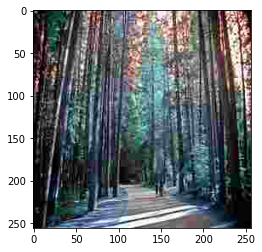

In [17]:
img = io.imread("/content/imgs/trainA/2009-12-24 12_09_12.jpg")
cv2.imwrite("/content/12.jpg", img, [int(cv2.IMWRITE_JPEG_QUALITY), 9])
img_l = io.imread("/content/12.jpg")
plt.imshow(img_l.squeeze())

In [19]:
dataset = HrLrImages(transform=ToTensor())

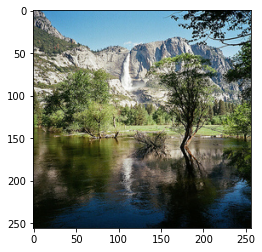

In [20]:
img = io.imread("/content/imgs/trainA/1230.jpg")
plt.imshow(img.squeeze())

In [21]:
len(dataset)

1231

In [22]:
dataloader = DataLoader(dataset, batch_size, shuffle=True)

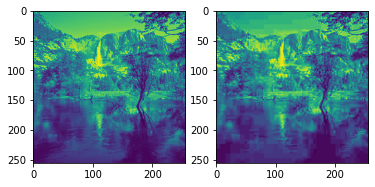

In [23]:
_, f = plt.subplots(1,2)
f[0].imshow(dataset[1230][0].squeeze())
f[1].imshow(dataset[1230][1].squeeze())

# Model structure

In [24]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        # Encoder part
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4, stride=2, padding=2, dilation=1),
            nn.BatchNorm2d(32),
            nn.PReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=2, dilation=1),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=1, padding=2, dilation=1),
            nn.BatchNorm2d(128),
            nn.PReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=4, stride=1, padding=2, dilation=1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(3),
            nn.Flatten()
        )

        # Decoder part: the output should be a 256x256 image

        self.decoder = nn.Sequential(
            torch.nn.Linear(128, 5096),
            torch.nn.ReLU(),
            torch.nn.Linear(5096, 256*256),
            torch.nn.Sigmoid()
        )

    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Training part

In [25]:
def train(model, dataloader, optimizer, loss_fn):
    min_loss = 1000
    for epoch in range(epochs):
        avg_loss = 0
        print(f"======== Epoch {epoch+1} ========")
        for batch, (X, y) in enumerate(dataloader):
            if batch <= 18:
                X, y = X.to(device), y.to(device)
                y = y.view(64, -1)
                pred = model(X)
                loss = loss_fn(pred, y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                avg_loss += loss
        avg_loss /= 19
        print(f"Epoch {epoch+1} completed. Average loss: {avg_loss:.5f}")
        if avg_loss >= min_loss * 1.15:
            break
    
    model_file_name = f"d{date.today()}l{min_loss:.5f}.pth"
    torch.save(model.state_dict(), model_file_name)
    print(f"The model was saved with the best loss: {min_loss:.5f}")

In [26]:
model = AE().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr)

In [27]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

335121931

In [28]:
train(model, dataloader, optimizer, loss_fn)

======== Epoch 1 ========
Epoch 1 completed. Average loss: 0.03996
======== Epoch 2 ========
Epoch 2 completed. Average loss: 0.02691
======== Epoch 3 ========
Epoch 3 completed. Average loss: 0.02391
======== Epoch 4 ========
Epoch 4 completed. Average loss: 0.02204
======== Epoch 5 ========
Epoch 5 completed. Average loss: 0.02155
======== Epoch 6 ========
Epoch 6 completed. Average loss: 0.02048
======== Epoch 7 ========
Epoch 7 completed. Average loss: 0.01953
======== Epoch 8 ========
Epoch 8 completed. Average loss: 0.01880
======== Epoch 9 ========
Epoch 9 completed. Average loss: 0.01749
======== Epoch 10 ========
Epoch 10 completed. Average loss: 0.01678


In [ ]:
d = dataset[0][0]
d.shape

torch.Size([3, 256, 256])

# Testing part

In [76]:
test_img_hr = io.imread("/content/imgs/testA/2011-05-29 13_29_21.jpg")
test_img_hr = cv2.cvtColor(test_img_hr, cv2.COLOR_BGR2GRAY)
cv2.imwrite("/content/test_img.jpg", test_img_hr, [int(cv2.IMWRITE_JPEG_QUALITY), 9])
test_img_lr = cv2.imread("/content/test_img.jpg")
test_img_lr = cv2.cvtColor(test_img_lr, cv2.COLOR_BGR2GRAY)

In [82]:
with torch.no_grad():
    model.eval()
    test_img_lr2hr = model(test_img_lr.unsqueeze(0))

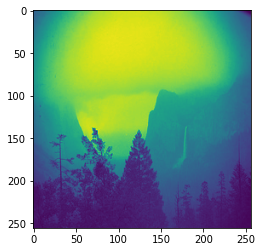

In [59]:
plt.imshow(test_img_hr.squeeze())

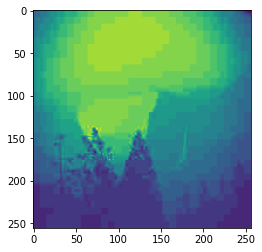

In [60]:
plt.imshow(test_img_lr.squeeze())

In [102]:
t = to_pil_image(test_img_lr2hr.reshape(256, 256))

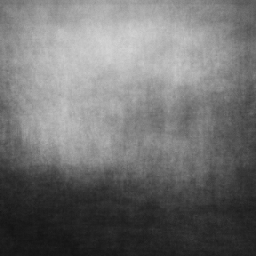

In [103]:
t